In [1]:
import settings.config as cfg

preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
group_sizes_to_test = cfg.group_sizes_to_test
group_similarity_to_test = cfg.group_similarity_to_test
group_number = cfg.group_number

print(group_number)

100


In [2]:
import pandas as pd

ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv") 
display(ratings_df.head(10))

,user,item,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


In [3]:
# computing similarity between each pair of users

import numpy as np

user_matrix = ratings_df.pivot_table(columns='item', index='user', values='rating')

user_id_set = set(ratings_df['user'])
user_id_indexes = user_matrix.index.values
user_matrix = user_matrix.fillna(0)
numpy_array = user_matrix.to_numpy()
sim_matrix = np.corrcoef(numpy_array)

# display(sim_matrix)
# display(list(user_id_indexes))
# display(user_id_set)

Text(0.5, 0, "Pearson's Correlation Coeficient")

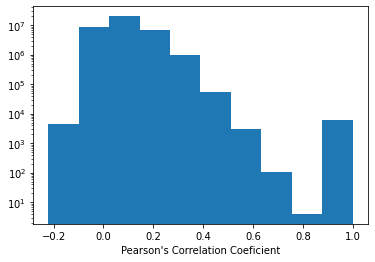

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sim_matrix.flatten())
plt.yscale("log")
plt.xlabel("Pearson's Correlation Coeficient")


In [5]:
import random
random.seed(1010101)

# Auxiliary functions from Kaya et al 
# https://github.com/mesutkaya/recsys2020/blob/8a8c7088bebc3309b8517f62248386ea7be39776/GFAR_python/create_group.py
def select_user_for_sim_group(group, sim_matrix, user_id_indexes, sim_threshold=0.4):
    '''
    Helper function to the generate_similar_user_groups function. Given already selected group members, it randomly
    selects from the remaining users that has a PCC value >= sim_threshold to any of the existing members.
    :param group:
    :param sim_matrix:
    :param user_id_indexes:
    :param sim_threshold: 0.5 is large size effect, 0.3 medium and 0.1 is small based on research (add citation!)
    :return:
    '''
    ids_to_select_from = set()
    for member in group:
        member_index = user_id_indexes.tolist().index(member)
        indexes = np.where(sim_matrix[member_index] >= sim_threshold)[0].tolist()
        user_ids = [user_id_indexes[index] for index in indexes]
        ids_to_select_from = ids_to_select_from.union(set(user_ids))
    candidate_ids = ids_to_select_from.difference(set(group))
    if len(candidate_ids) == 0:
        return None
    else:
        selection = random.sample(candidate_ids, 1)
        return selection[0]
    
    
def select_user_for_divergent_group(group, sim_matrix, user_id_indexes, sim_threshold=0.0):
    '''
    Helper function to the generate_similar_user_groups function. Given already selected group members, it randomly
    selects from the remaining users that has a PCC value < sim_threshold to any of the existing members.
    :param group:
    :param sim_matrix:
    :param user_id_indexes:
    :param sim_threshold: 0.5 is large size effect, 0.3 medium and 0.1 is small based on research (add citation!)
    :return:
    '''
    ids_to_select_from = set()
    for member in group:
        member_index = user_id_indexes.tolist().index(member)
        indexes = np.where(sim_matrix[member_index] < sim_threshold)[0].tolist()
        user_ids = [user_id_indexes[index] for index in indexes]
        ids_to_select_from = ids_to_select_from.union(set(user_ids))
    candidate_ids = ids_to_select_from.difference(set(group))
    if len(candidate_ids) == 0:
        return None
    else:
        selection = random.sample(candidate_ids, 1)
        return selection[0]


# generation of random, similar and divergent groups, revised from Kaya et al 
# https://github.com/mesutkaya/recsys2020/blob/8a8c7088bebc3309b8517f62248386ea7be39776/GFAR_python/create_group.py
def generate_random_groups(user_id_set):
    groups_list = list()
    for group_size in group_sizes_to_test:
        for i in range(group_number):
            group = random.sample(user_id_set, group_size)
            groups_list.append({"group_size" : group_size, "group_similarity" : 'random', "group_members" : group})
    return groups_list


def generate_similar_groups(user_id_indexes, similarity_matrix):
    groups_list = list()
    for group_size in group_sizes_to_test:
        groups_size_list = list()
        while(len(groups_size_list) < group_number):
            group = random.sample(user_id_set, 1)
            while len(group) < group_size:
                new_member = select_user_for_sim_group(group, similarity_matrix, user_id_indexes, sim_threshold=cfg.similar_threshold)
                if new_member is None:
                    break
                group.append(new_member)
            if len(group) == group_size:
                groups_size_list.append({"group_size" : group_size, "group_similarity" : 'similar', "group_members" : group})
        groups_list.extend(groups_size_list)
        print(len(groups_list))
    return groups_list

def generate_divergent_groups(user_id_indexes, similarity_matrix):
    groups_list = list()
    for group_size in group_sizes_to_test:
        groups_size_list = list()
        while(len(groups_size_list) < group_number):
            group = random.sample(user_id_set, 1)
            while len(group) < group_size:
                new_member = select_user_for_divergent_group(group, similarity_matrix, user_id_indexes, sim_threshold=cfg.dissimilar_threshold)
                if new_member is None:
                    break
                group.append(new_member)
            if len(group) == group_size:
                groups_size_list.append({"group_size" : group_size, "group_similarity" : 'divergent', "group_members" : group})
        groups_list.extend(groups_size_list)
        print(len(groups_list))
    return groups_list



def generate_similar_with_one_divergent_groups(user_id_indexes, similarity_matrix):
    groups_list = list()
    for group_size in group_sizes_to_test:
        groups_size_list = list()
        while(len(groups_size_list) < group_number):
            group = random.sample(user_id_set, 1)
            while len(group) < (group_size-1):
                new_member = select_user_for_sim_group(group, similarity_matrix, user_id_indexes, sim_threshold=cfg.similar_threshold)
                if new_member is None:
                    break
                group.append(new_member)
            
            dissimilar_member = select_user_for_divergent_group(group, similarity_matrix, user_id_indexes, sim_threshold=cfg.dissimilar_threshold)
            group.append(dissimilar_member)
            
            if len(group) == group_size:
                groups_size_list.append({"group_size" : group_size, "group_similarity" : 'similar_one_divergent', "group_members" : group})
        groups_list.extend(groups_size_list)
        print(len(groups_list))
    return groups_list

In [6]:
group_list_random = generate_random_groups(user_id_set)
display(len(group_list_random))

group_list_similar = generate_similar_groups(user_id_indexes, sim_matrix)
display(len(group_list_similar))

group_list_divergent = generate_divergent_groups(user_id_indexes, sim_matrix)
display(len(group_list_divergent))

group_list_sim_one_div = generate_similar_with_one_divergent_groups(user_id_indexes, sim_matrix)
display(len(group_list_sim_one_div))

300

100
200
300


300

100
200
300


300

100
200
300


300

In [7]:
group_list = group_list_random + group_list_similar + group_list_divergent + group_list_sim_one_div
#group_list = group_list_sim_one_div

group_dict = dict()
for group_id, group in zip(range(len(group_list)), group_list):
    group_dict[group_id] = group
display(group_dict)

{0: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [4805, 5428]},
 1: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [5251, 146]},
 2: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [3916, 4539]},
 3: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [2059, 5558]},
 4: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [1789, 463]},
 5: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [3234, 4068]},
 6: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [5216, 4855]},
 7: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [339, 5736]},
 8: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [153, 4515]},
 9: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [3450, 2157]},
 10: {'group_size': 2,
  'group_similarity': 'random',
  'group_members': [707, 2380]},
 11: {'group_size': 2,
  'group_simi

In [8]:
# simple similarity viewer per group
np.set_printoptions(precision=4, suppress=True)
idx = 804
member_index = [user_id_indexes.tolist().index(member) for member in group_dict[idx]["group_members"]]
s = sim_matrix[member_index]
s[:,member_index]

array([[ 1.    , -0.1002,  0.3063,  0.1441,  0.2461,  0.2909,  0.1838,
        -0.0434],
       [-0.1002,  1.    , -0.1258, -0.102 , -0.1291, -0.1078, -0.1812,
         0.4661],
       [ 0.3063, -0.1258,  1.    ,  0.2142,  0.1761,  0.1704,  0.2664,
        -0.0674],
       [ 0.1441, -0.102 ,  0.2142,  1.    ,  0.1981,  0.2662,  0.3186,
        -0.062 ],
       [ 0.2461, -0.1291,  0.1761,  0.1981,  1.    ,  0.1434,  0.1899,
        -0.0368],
       [ 0.2909, -0.1078,  0.1704,  0.2662,  0.1434,  1.    ,  0.3399,
        -0.0479],
       [ 0.1838, -0.1812,  0.2664,  0.3186,  0.1899,  0.3399,  1.    ,
        -0.1082],
       [-0.0434,  0.4661, -0.0674, -0.062 , -0.0368, -0.0479, -0.1082,
         1.    ]])

In [9]:
import pickle
pickle.dump(group_dict, open(preprocessed_dataset_folder+"/group_composition.pkl", "wb"))

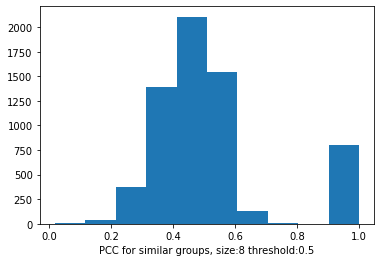

In [10]:
group_similarity = "similar"
group_size = 8
histogram_list = []
for gid in group_dict.keys():
    g = group_dict[gid]
    if g["group_similarity"] == group_similarity and g["group_size"] == group_size:
        member_index = [user_id_indexes.tolist().index(member) for member in g["group_members"]]
        s = sim_matrix[member_index]
        histogram_list.extend(s[:,member_index].flatten().tolist())

        
plt.hist(histogram_list)
#plt.yscale("log")
plt.xlabel("PCC for "+group_similarity+" groups, size:"+str(group_size)+" threshold:"+str(cfg.similar_threshold))    
plt.savefig("pcc_"+group_similarity+"_"+str(group_size)+"_"+str(int(cfg.similar_threshold*10))+".png", dpi=300)

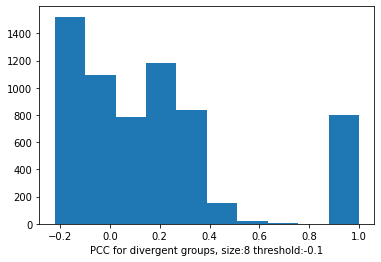

In [11]:
group_similarity = "divergent"
group_size = 8
histogram_list = []
for gid in group_dict.keys():
    g = group_dict[gid]
    if g["group_similarity"] == group_similarity and g["group_size"] == group_size:
        member_index = [user_id_indexes.tolist().index(member) for member in g["group_members"]]
        s = sim_matrix[member_index]
        histogram_list.extend(s[:,member_index].flatten().tolist())

        
plt.hist(histogram_list)
#plt.yscale("log")
plt.xlabel("PCC for "+group_similarity+" groups, size:"+str(group_size)+" threshold:"+str(cfg.dissimilar_threshold))    
plt.savefig("pcc_"+group_similarity+"_"+str(group_size)+"_"+str(int(cfg.dissimilar_threshold*10))+".png", dpi=300)